In [159]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling, IMDB

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle
import spacy

In [50]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Language Modeling

### Data

The [large movie view dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50,000 reviews from IMDB. The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews.

The **sentiment classification task** consists of predicting the polarity (positive or negative) of a given text.

However, before we try to classify *sentiment*, we will simply try to create a *language model*; that is, a model that can predict the next word in a sentence. Why? Because our model first needs to understand the structure of English, before we can expect it to recognize positive vs negative sentiment.

So our plan of attack is the same as we used for Dogs v Cats: pretrain a model to do one thing (predict the next word), and fine tune it to do something else (classify sentiment).

Unfortunately, there are no good pretrained language models available to download, so we need to create our own. To follow along with this notebook, we suggest downloading the dataset from [this location](http://files.fast.ai/data/aclImdb.tgz) on files.fast.ai.

In [51]:
PATH = '/fastai/data/aclImdb/'
TRN_PATH = 'train/all/'
VAL_PATH = 'test/all/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

README  imdb.vocab  imdbEr.txt  models/  test/  train/


lets look inside the training folder

In [52]:
trn_files = !ls {TRN}
trn_files[:10]

['0_0.txt',
 '0_3.txt',
 '0_9.txt',
 '10000_0.txt',
 '10000_4.txt',
 '10000_8.txt',
 '10001_0.txt',
 '10001_10.txt',
 '10001_4.txt',
 '10002_0.txt']

lets check out a sample review

In [53]:
review = !cat {TRN}{trn_files[6]}
trn_files[6]
review


'10001_0.txt'

["Everybody has seen 'Back To The Future,' right? Whether you LIKE that movie or not, you've seen an example of how to make a time-travel movie work. A torn-up poster for 'Back To The Future' shows up in this movie, representing, perhaps unintentionally, what the makers of 'Tangents' (aka 'Time Chasers') did to the time-travel formula. Then again, the movie claims to have been made in 1994, but it looks -- and sounds -- like it was produced at least ten years earlier, so maybe they achieved time-travel after all.<br /><br />Start with an intensely unappealing leading man. I mean, what woman doesn't love gangly, whiny, lantern-jawed, butt-chinned, mullet-men with Coke-bottle glasses? Oh, none of you? Prepare to tough it out, ladies, cuz that's what this movie gives you.<br /><br />Second, add a leading lady who -- while not entirely unattractive -- represents many '80s clichés: big hair, too much makeup, two different plaids, shoulder pads, acid-washed mom-jeans, etc.<br /><br />Throw i

This was a 0 review and the text conveys that. Next we will check how many words are in the dataset

In [54]:
!find {TRN} -name '*.txt' | xargs cat | wc -w

17486581


In [55]:
!find {VAL} -name '*.txt' | xargs cat | wc -w

5686719


Before we can analyze text, we must first *tokenize* it. This refers to the process of splitting a sentence into an array of words (or more generally, into an array of *tokens*).

*Note:* If you get an error like:

    Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.
    
then you need to install the Spacy language model by running this command on the command-line:

    $ python -m spacy download en

In [56]:
spacy_tok = spacy.load('en')
type(spacy_tok)

spacy.lang.en.English

spacy_tok is an object of type English, we now concatanate this with space

In [57]:
' '.join([sent.string.strip() for sent in spacy_tok(review[0])])

"Everybody has seen ' Back To The Future , ' right ? Whether you LIKE that movie or not , you 've seen an example of how to make a time - travel movie work . A torn - up poster for ' Back To The Future ' shows up in this movie , representing , perhaps unintentionally , what the makers of ' Tangents ' ( aka ' Time Chasers ' ) did to the time - travel formula . Then again , the movie claims to have been made in 1994 , but it looks -- and sounds -- like it was produced at least ten years earlier , so maybe they achieved time - travel after all.<br /><br />Start with an intensely unappealing leading man . I mean , what woman does n't love gangly , whiny , lantern - jawed , butt - chinned , mullet - men with Coke - bottle glasses ? Oh , none of you ? Prepare to tough it out , ladies , cuz that 's what this movie gives you.<br /><br />Second , add a leading lady who -- while not entirely unattractive -- represents many ' 80s clichés : big hair , too much makeup , two different plaids , shoul

We use Pytorch's [torchtext](https://github.com/pytorch/text) library to preprocess our data, telling it to use the wonderful [spacy](https://spacy.io/) library to handle tokenization.

First, we create a torchtext *field*, which describes how to preprocess a piece of text - in this case, we tell torchtext to make everything lowercase, and tokenize it with spacy.

In [58]:
TEXT = data.Field(lower=True, tokenize="spacy")

fastai works closely with torchtext. We create a ModelData object for language modeling by taking advantage of `LanguageModelData`, passing it our torchtext field object, and the paths to our training, test, and validation sets. In this case, we don't have a separate test set, so we'll just use `VAL_PATH` for that too.

As well as the usual `bs` (batch size) parameter, we also now have `bptt`; this define how many words are processing at a time in each row of the mini-batch. More importantly, it defines how many 'layers' we will backprop through. Making this number higher will increase time and memory requirements, but will improve the model's ability to handle long sentences.

In [59]:
bs=64; bptt=70

In [60]:
FILES = dict(train=TRN_PATH, validation=VAL_PATH, test= VAL_PATH)
md = LanguageModelData.from_text_files(PATH,TEXT,**FILES,bs=bs,bptt=bptt,min_freq=10)

After building our `ModelData` object, it automatically fills the TEXT object wuth very important attribute: TEXT.vocab. This is a vocabulary which stores which words (or tokens) have been seen in the text, and how each word will be mapped to a unique integer id. We will need to use this information again later, so we save it.


*(Technical note: python's standard `Pickle` library can't handle this correctly, so at the top of this notebook we used the `dill` library instead and imported it as `pickle`)*.

In [61]:
!ls {PATH}

README	imdb.vocab  imdbEr.txt	models	test  train


In [62]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

Here are the: #batches; #unique tokens in teh vocab; # tokens in the training set; # sentences

In [63]:
len(md.trn_dl),md.nt,len(md.trn_ds),len(md.trn_ds[0].text)

(4583, 37392, 1, 20540756)

This is the start of the mapping integer IDs to unique tokens

In [64]:
#itos: int-to-string
TEXT.vocab.itos[:12]

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

In [65]:
#stoi: string to int
TEXT.vocab.stoi['the']

2

Note that in `LanguageModelData` there is only one item in the dataset: all the workds of the text joined together

In [66]:
md.trn_ds[0].text[:12]

['picking',
 'up',
 'the',
 'jacket',
 'of',
 'this',
 'dvd',
 'in',
 'the',
 'video',
 'store',
 'i']

torchtext would handle turning these words to integer IDs for us automatically

In [80]:
TEXT.numericalize([md.trn_ds[0].text[:12]],device=torch.device("cuda:0"))

tensor([[3701],
        [  68],
        [   2],
        [5641],
        [   7],
        [  13],
        [ 300],
        [  10],
        [   2],
        [ 392],
        [1089],
        [  12]], device='cuda:0')

Our `LanguageModelData` object will create batches with 64 columns (that's our batch size), and varying sequence lengths of around 80 tokens (that's our `bptt` parameter - *backprop through time*).

Each batch also contains the exact same data as labels, but one word later in the text - since we're trying to always predict the next word. The labels are flattened into a 1d array.

In [81]:
next(iter(md.trn_dl))

(tensor([[ 3701,   297,     9,  ...,  1667,    12,    14],
         [   68, 13351,   359,  ...,    43,   173,    33],
         [    2,    51,    24,  ...,   472,     6,   324],
         ...,
         [    7,    91,   157,  ...,     3,     6,    83],
         [   13,  1001,    56,  ...,   500,  1943,   867],
         [   25,    52,     7,  ...,    13,     7,    54]], device='cuda:0'),
 tensor([   68, 13351,   359,  ...,  1659,  1310,    13], device='cuda:0'))

## Train

We have a number of parameters to set, more on these later.

In [82]:
em_sz = 200 #size of embedding vectore for NLP the size is larger 50 to 400
nh = 500    #number of hidden activations per layer
nl = 3      #number of layers

Researchers have found that large amounts of momentum (which we'll learn later) don't work well with these kinds of RNN models, so we create a version of teh Adam optimizer with less momentum than its default of 0.9

In [83]:
opt_fn = partial(optim.Adam, betas=(0.7,0.99))

fastai uses a variant of the state of the art [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182) developed by Stephen Merity. A key feature of this model is that it provides excellent regularization through [Dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout). There is no simple way known (yet!) to find the best values of the dropout parameters below - you just have to experiment...

However, the other parameters (`alpha`, `beta`, and `clip`) shouldn't generally need tuning.

In [85]:
#create the learner object
learner =  md.get_model(opt_fn, em_sz, nh, nl, dropouti=0.05, dropout=0.05, wdrop=0.1,dropoute=0.02,dropouth=0.05)
learner_reqfn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [86]:
learner.lr_find()

 75%|███████▌  | 3445/4583 [05:24<01:47, 10.62it/s, loss=20.9]

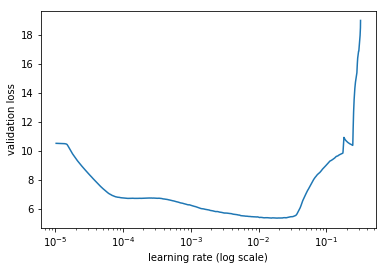

In [87]:
learner.sched.plot()

In [88]:
learner.fit(1e-3,3,wds=1e-6,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss                                 
    0      5.26136    5.172704  
    1      4.880401   4.76533                                  
    2      4.787768   4.692676                                 
    3      4.711147   4.588814                                 
    4      4.625468   4.504137                                 
    5      4.567585   4.462355                                 
    6      4.546808   4.452587                                 


[4.452587369359971]

In [89]:
learner.fit(3e-3,4,wds=1e-6,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss                                 
    0      4.57223    4.427007  
    1      4.56946    4.427515                                 
    2      4.457805   4.350482                                 
    3      4.555827   4.42498                                  
    4      4.473307   4.354355                                 
    5      4.398312   4.297179                                 
    6      4.345317   4.280065                                 
    7      4.508099   4.390334                                 
    8      4.485541   4.366297                                 
    9      4.448348   4.330054                                 
    10     4.394573   4.298604                                 
    11     4.362389   4.265119                                 
    12     4.317964   4.240648                                 
    13     4.297018   4.226619                                 
    14     4.270809   4.223768                                 


[4.2237679414260745]

In [90]:
learner.save_encoder('adam_enc')

In [92]:
learner.load_encoder('adam_enc')

In [93]:
learner.fit(3e-3,1,wds=1e-6,cycle_len=10)

epoch      trn_loss   val_loss                                 
    0      4.463968   4.356095  
    1      4.441323   4.340704                                 
    2      4.41841    4.317432                                 
    3      4.381581   4.292304                                 
    4      4.371396   4.270415                                 
    5      4.331083   4.241518                                 
    6      4.308314   4.220267                                 
    7      4.274648   4.20569                                  
    8      4.249358   4.197425                                 
    9      4.241075   4.196095                                 


[4.1960945478130345]

In the sentiment analysis section, we'll just need half of the language model, - the encoder, so we save that part.

In [94]:
learner.save_encoder('adam3_10_enc')

In [95]:
learner.load_encoder('adam3_10_enc')

Language modeling accuracy is generally measured using the metric preplexity, which is simply exp() ofr the loss function we used.

In [96]:
math.exp(4.196)

66.42011849679963

In [97]:
#lets dump the TEXT object again
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

## Test

We can play around with our language model a bit to check if working OK. First let's create a short text to prime a set of predictions. We'll use our torchtext field to numericalize it so we can feed it to our language model.

In [149]:
m = learner.model
ss = """. Thinking about it now, I feel it was fantastic, some neat drama"""
s = [TEXT.preprocess(ss)]
t = TEXT.numericalize(s,device=torch.cuda.current_device())
t
" ".join(s[0])

tensor([[   4],
        [ 549],
        [  54],
        [  11],
        [ 174],
        [   3],
        [  12],
        [ 245],
        [  11],
        [  19],
        [ 844],
        [   3],
        [  59],
        [3239],
        [ 457]], device='cuda:0')

'. thinking about it now , i feel it was fantastic , some neat drama'

We have'nt yet added methods to make it easy to test a language model, so we'll need to manually go through the steps

In [150]:
# Set batch size to 1
m[0].bs=1
#Turn off dropout
m.eval()
#Reset hidden state
m.reset()
#Get predictions from model
res,*_ = m(t)
#Put the batch size back to what it was
m[0].bs=bs

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(37392, 200, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(37392, 200, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(200, 500)
      )
      (1): WeightDrop(
        (module): LSTM(500, 500)
      )
      (2): WeightDrop(
        (module): LSTM(500, 200)
      )
    )
    (dropouti): LockedDropout()
    (dropouths): ModuleList(
      (0): LockedDropout()
      (1): LockedDropout()
      (2): LockedDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=200, out_features=37392, bias=False)
    (dropout): LockedDropout()
  )
)

Lets see what the top 10 predictions were for the next word after our short text:

In [153]:
#[TEXT.vocab.itos[d] for d in to_np(res[-1])]
res
res.shape
res[-1]
res[-1].shape

tensor([[ -0.9626,  -4.0719,   0.7891,  ...,  -4.0841,  -4.0901,  -4.0767],
        [ -1.9051,  -7.1286,   0.4004,  ...,  -7.1296,  -7.1169,  -7.1334],
        [ -1.0541,  -8.4944,   1.5900,  ...,  -8.4885,  -8.4587,  -8.4821],
        ...,
        [ -1.5207,  -9.7643,  -1.5407,  ...,  -9.7647,  -9.7985,  -9.7984],
        [ -0.5365,  -9.1048,  -4.9464,  ...,  -9.0892,  -9.1105,  -9.0980],
        [ -1.7994, -10.4544,  -2.9510,  ..., -10.4564, -10.4746, -10.4479]],
       device='cuda:0', grad_fn=<ViewBackward>)

torch.Size([15, 37392])

tensor([ -1.7994, -10.4544,  -2.9510,  ..., -10.4564, -10.4746, -10.4479],
       device='cuda:0', grad_fn=<SelectBackward>)

torch.Size([37392])

res is a tensor of predictions for all the 37392 words in the vocab stating whats the probability that this word would be next, shape of res needs to be studied.

`res[-1]` provides the last sentence predictions

In [152]:
nexts = torch.topk(res[-1],10)[1] # topk returns values,indices - so [1] returns indices only
nexts ; [TEXT.vocab.itos[o] for o in to_np(nexts)]

tensor([ 3,  5,  4, 21, 10, 14, 54, 28, 40,  8], device='cuda:0')

[',', 'and', '.', 'with', 'in', 'that', 'about', '(', 'at', 'to']

we use torch.topk to find the top k values in the input which is `res[-1]` predictions for sentence next word, we give 10 so top 10 is returned. 
topk returns a tuple of values,indices we use the indices hence `[1]`
the returned value is a tensor of indices we pass it to itos on vocab to ge the actual words from the vocab(37392 long)

Now lets see if our model cna generate a bit more text all byt itself!

In [154]:
print(ss,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]               #get top 2 word predictions
    w=n[1] if n.data[0]==0 else n[0]   #check if 0 and take one of two
    print(TEXT.vocab.itos[w],end=' ')  
    res,*_ = m(n.unsqueeze(0))         #m() takes a second order tensor but n is a 1 order tensor, so unsqueeze
                                       #unsqueeze takes tensor([ 6, 29] and converts to tensor([[ 6, 29]]
    #res,*_ = m(n)
print('...')

. Thinking about it now, I feel it was fantastic, some neat drama 

, the who not the different different town . the lives . and they film is n't have sense sense /><br the is a a best , the the " " " " " " " " " " " " " " " " " " " " " ...


## Sentiment

We'll need the saved Vocab from the language model, since we ned to make sure the same word map to the same IDs. when we tested we might have introduced some new words

In [237]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

`sequential=False` tells torchtext that text field should not be tokenized( since in this case we want to store the positive (_7  t _9) or nengative (_0 to _4) label from the text file name.

`splits` is a torchtext method that creates train and test sets. The IMDB dataset is built into torchtext, so we can take advantage of that. Take a look at `lang_model-arxiv.ipynb` to see how to define your own fastai/torchtext datasets

In [238]:
IMDB_LABEL = data.Field(sequential=False)
splits = torchtext.datasets.IMDB.splits(TEXT, IMDB_LABEL, '/fastai/data/')

splits is returned as a tuple with datsets for train and test sets

In [239]:
t = splits[0].examples[0]

t.label, ' '.join(t.text[:16])

('pos',
 'zentropa has much in common with the third man , another noir - like film set')

fastai can create a ModelData object directly from torchtext splits.

In [240]:
md2 =  TextData.from_splits(PATH,splits,bs)

In [241]:
m3 = md2.get_model(opt_fn,1500,bptt,emb_sz=em_sz,n_hid=nh,n_layers=nl,
                  dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam3_10_enc')


BEcasue we're fine-tuning a pretrained model, we'll use differential learning rates, and also increase the max gradient for clipping, to allow the SGDR to work better.

In [242]:
m3.clip=25.
lrs = np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [243]:
bs
type(md2)
type(m3)
m3.model[0].bs
PATH


64

fastai.nlp.TextData

fastai.nlp.RNN_Learner

1

'/fastai/data/aclImdb/'

In [244]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy],cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.639741   0.651242   0.81117   


[0.6512420465206471, 0.8111702292798405]

epoch      trn_loss   val_loss   accuracy                    
    0      0.464076   0.27529    0.891918  


[0.2752897033313903, 0.8919183444207585]

In [245]:
m3.fit(lrs,7,metrics=[accuracy],cycle_len=2,cycle_save_name='imdb2')

epoch      trn_loss   val_loss   accuracy                    
    0      0.432585   0.265562   0.894136  
    1      0.414081   0.241599   0.901543                    
    2      0.366688   0.225273   0.911241                    
    3      0.355082   0.237793   0.90426                     
    4      0.355593   0.261389   0.901917                    
    5      0.323906   0.237203   0.909261                    
    6      0.337199   0.221464   0.915517                    
    7      0.330156   0.232349   0.913025                    
    8      0.319553   0.251486   0.906905                    
    9      0.322337   0.231094   0.916728                    
    10     0.326509   0.237996   0.913243                    
    11     0.303482   0.236787   0.917994                    
    12     0.30429    0.216942   0.922938                    
    13     0.293487   0.238145   0.917235                    


[0.23814491024913073, 0.9172351211900582]

In [246]:
m3.fit(3e-3,3,metrics=[accuracy],cycle_len=1,cycle_mult=2,cycle_save_name='imdb3')

epoch      trn_loss   val_loss   accuracy                    
    0      0.267451   0.230853   0.91846   
    1      0.248803   0.270116   0.918509                    
    2      0.186969   0.248587   0.926583                    
    3      0.204876   0.266799   0.917858                    
    4      0.170832   0.347148   0.913486                    
    5      0.122626   0.36135    0.914163                    
    6      0.104048   0.608301   0.89956                      


[0.6083013031634404, 0.8995600131942838]

In [248]:
#load a cycle with good accuracy and calculate score
m3.load_cycle('imdb3',2)

In [249]:
accuracy_np(*m3.predict_with_targs())

0.90412

A recent paper from Bradbury et al, [Learned in translation: contextualized word vectors](https://einstein.ai/research/learned-in-translation-contextualized-word-vectors), has a handy summary of the latest academic research in solving this IMDB sentiment analysis problem. Many of the latest algorithms shown are tuned for this specific problem.

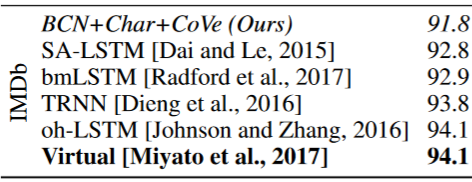


As you see, we just got a new state of the art result in sentiment analysis, decreasing the error from 5.9% to 5.5%! You should be able to get similarly world-class results on other NLP classification problems using the same basic steps.

There are many opportunities to further improve this, although we won't be able to get to them until part 2 of this course...

## End